#Description

To train this model, we first obtained the sector indices and labeled them using a Label Encoder. We then partitioned the data into training and testing sets (80-20 split). To feed the data into the HuggingFace transformers, we converted the dataframes into datasets.

We used the 'roberta-base' transformer from the AutoModelForSequenceClassification to train the model. The model was trained for 2 epochs.

#Preprocessing the dataset

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("wrds_data.csv")
data.head()

,Unnamed: 0,conm,gind,gsector,naics,busdesc,spcindcd,GICS_Sector,naics_main,NAICS_Sector
0,2,AAI CORP,NaN,NaN,NaN,"AAI Corporation, together with its subsidiarie...",230.0,NaN,No,NaN
1,3,A.A. IMPORTING CO INC,255040.0,25.0,442110.0,"A.A. Importing Company, Inc. designs, manufact...",449.0,Consumer Discretionary,44,Retail Trade
2,4,AAR CORP,201010.0,20.0,423860.0,AAR Corp. provides products and services to co...,110.0,Industrials,42,Wholesale Trade
3,5,A.B.A. INDUSTRIES INC,NaN,NaN,NaN,A.B.A. Industries Inc. was acquired by McSwain...,110.0,NaN,No,NaN
4,6,ABC INDS INC,NaN,NaN,NaN,"ABC Industries, Inc. manufactures and supplies...",415.0,NaN,No,NaN


In [ ]:
data = data[data.columns[2:]]

In [ ]:
data.dropna(subset=['gind'], how='any', inplace=True)

In [ ]:
data['gind'] = data['gind'].astype(int)

In [ ]:
data.drop(columns = ["spcindcd", "naics_main", "NAICS_Sector", "GICS_Sector", "naics", "gsector"], axis=1, inplace=True)

In [ ]:
# This is for classifying the other branches: Industry Group(item/100) and Sector(item/10000)

import math

list = []
for item in data["gind"]:
  list.append(math.floor(item/10000))

data["gind"] = list

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data["gind"] = encoder.fit_transform(data["gind"])
data["gind"].value_counts()

6     5363
7     5192
3     4662
5     4565
2     3934
1     3833
0     2822
4     1433
8     1285
9      740
10     509
Name: gind, dtype: int64

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


#Train and test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data["busdesc"],  data["gind"], test_size=0.2, random_state=0)

#Converting dataframes to datasets

In [ ]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

df_train.columns = ["Desc", "label"]
df_test.columns = ["Desc", "label"]

In [ ]:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files={"train": "train.csv", "test": "test.csv"})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1af6c33991c3a39d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
labels_num = len(set(dataset["train"]["label"]))
labels_num

11

#Setting up and training the transformer

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=labels_num)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
encoded_dataset = dataset.map(lambda t: tokenizer(t['Desc'],  truncation=True), batched=True, load_from_cache_file=False)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
encoded_dataset["train"]

Dataset({
    features: ['Desc', 'label', 'input_ids', 'attention_mask'],
    num_rows: 27470
})

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", num_train_epochs=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Desc. If Desc are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 27470
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch siz

Epoch,Training Loss,Validation Loss
1,0.172200,1.562204
2,0.113300,1.590519


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=6868, training_loss=0.15242217346617976, metrics={'train_runtime': 492.5131, 'train_samples_per_second': 111.55, 'train_steps_per_second': 13.945, 'total_flos': 1677158104879176.0, 'train_loss': 0.15242217346617976, 'epoch': 2.0})

In [ ]:
y_pred = trainer.predict(encoded_dataset['test'])
print(y_pred.predictions.shape, y_pred.label_ids.shape)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Desc. If Desc are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6868
  Batch size = 8


(6868, 11) (6868,)


#Predictions and results

In [ ]:
y_pred = y_pred.predictions

In [ ]:
import numpy as np

y_pred = [np.argmax(y_pred[i]) for i in range(0,len(y_pred))]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print(confusion_matrix(df_test["label"], y_pred))
print(classification_report(df_test["label"], y_pred))
print("F1 score is: "+ (str)(f1_score(df_test["label"], y_pred, average='micro')))

[[483  18  16   5   1   2   6   5   0   9   0]
 [ 14 680  45  17  10  10   7   6   2   2   0]
 [ 21  45 474  74  10  30  15  82   6  11   1]
 [  3  12  77 679  33  26  19  64  42   4   1]
 [  1  10   5  22 195  21   4   1   0   1   0]
 [  3  12  10  12  19 795   8  16   1   2   0]
 [  4  12  19  19   2  14 962   8   4   3  11]
 [  8   8  69  41   3  30  14 889  36   5   3]
 [  0   1   8  32   1   8   4  36 146   0   0]
 [  9   1   8   2   0   1   1   1   0 126   1]
 [  0   3   3   6   2   3  37   0   3   0  56]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       545
           1       0.85      0.86      0.85       793
           2       0.65      0.62      0.63       769
           3       0.75      0.71      0.73       960
           4       0.71      0.75      0.73       260
           5       0.85      0.91      0.87       878
           6       0.89      0.91      0.90      1058
           7       0.80      0.80      0.80      

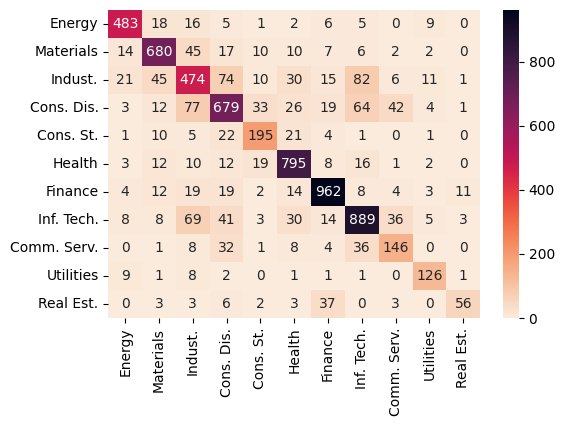

Scores from classifying the industry groups:

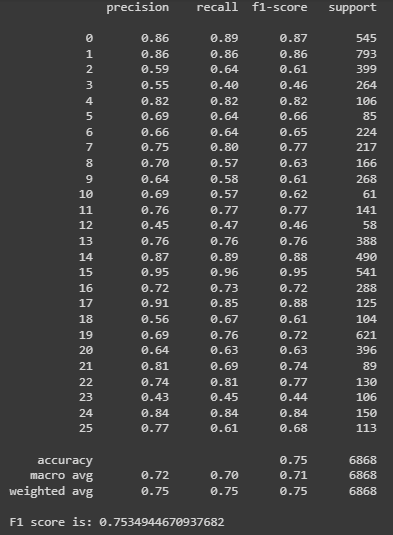